# Import Statements
All the libraries required by the cells in this notebook are imported in the following cell and thus it needs to be executed before other cells.


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from tqdm import tqdm
from huggingface_hub import from_pretrained_keras
from huggingface_hub import HfFolder, notebook_login
from kaggle_secrets import UserSecretsClient
import tensorflow as tf
from PIL import Image, ImageOps, ImageEnhance
from io import BytesIO
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import os
import pandas as pd
import json
import random
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

2025-10-09 20:52:58.677629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760043178.886574      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760043178.945634      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Google Derm Foundation Inference for Embedding Generation

The cells under this heading contain codes that enable embedding generation using Google's Derm Foundation model for images. 

Required:
- HuggingFace authentication key
- Access to the dataset hosted at [Dataset of Annotated Oral Cavity Images for Oral Cancer Detection](https://zenodo.org/records/10664056)

In [ ]:
CSV_FILE = '/kaggle/input/zenodo-oscc-dataset/Imagewise_Data.csv'
BASE_DIR = '/kaggle/input/zenodo-oscc-dataset/Zenodo_OSCC_Dataset/Zenodo_OSCC_Dataset'

## HuggingFace Authentication

In [ ]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

if HfFolder.get_token() is None:
    notebook_login(secret_value_0)

!mkdir -p ~/.huggingface
!echo -n "{secret_value_0}" > ~/.huggingface/token

## Image Preprocessing according to Derm Foundation Model's requirements

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file=CSV_FILE,
                 base_dir=BASE_DIR):
        
        self.df = pd.read_csv(csv_file)
        self.label_map = {"Benign": 0, "OPMD": 1, "OCA": 1}

        self.image_bytes = []
        self.labels = []

        class0_images = []

        for i, row in self.df.iterrows():
            img_name = row["Image Name"]
            category = row["Category"]

            if category == 'Healthy':
                continue

            img_path = os.path.join(base_dir, category, img_name + ".jpg")

            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")

            print(f"Processing image {i}: {img_name}")

            # Load image
            img = Image.open(img_path).convert("RGB")
            
            # Resize using Lanczos interpolation (better for shrinking)
            img = img.resize((896, 896), Image.Resampling.LANCZOS)

            # Apply CLAHE
            img = self.apply_clahe(img)

            # Convert to bytes
            buf = BytesIO()
            img.save(buf, format="PNG")
            img_bytes = buf.getvalue()
            self.image_bytes.append(img_bytes)

            label = self.label_map[category]
            self.labels.append(label)

            if label == 0:
                class0_images.append(img)

        # Balancing the dataset by augmenting class 0 samples
        count_class0 = len(class0_images)
        count_class1 = self.labels.count(1)

        print(f"Class 0 count: {count_class0}, Class 1 count: {count_class1}")

        if count_class0 < count_class1 and count_class0 > 0:
            needed = count_class1 - count_class0
            print(f"Augmenting {needed} images from class 0 to balance the dataset.")

            for i in range(count_class0):
                # Randomly choose a class 0 image
                img = class0_images[i]

                # Apply augmentation
                aug_img = self.augment_image(img)

                # Apply CLAHE again to augmented image
                aug_img = self.apply_clahe(aug_img)

                # Convert to PNG bytes
                buf = BytesIO()
                aug_img.save(buf, format="PNG")
                self.image_bytes.append(buf.getvalue())

                # Add corresponding label
                self.labels.append(0)

        print(f"Final dataset size: {len(self.image_bytes)} images and {len(self.labels)} labels")

        assert len(self.image_bytes) == len(self.labels), "Mismatch in images and labels"

    def apply_clahe(self, img):
        """Apply CLAHE channel-wise to an RGB image"""
        img_np = np.array(img)

        # Convert RGB to LAB color space
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(4, 4))
        cl = clahe.apply(l)

        # Merge channels and convert back to RGB
        lab = cv2.merge((cl, a, b))
        rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        return Image.fromarray(rgb)

    def augment_image(self, img):
        """Apply random augmentations like flip, rotation, brightness"""
        # Random horizontal or vertical flip
        if random.random() < 0.5:
            img = ImageOps.mirror(img)
        if random.random() < 0.5:
            img = ImageOps.flip(img)

        # Random rotation between -15 and 15 degrees
        angle = random.uniform(-30, 30)
        img = img.rotate(angle, resample=Image.Resampling.BILINEAR)

        return img

    def __len__(self):
        return len(self.image_bytes)

    def __getitem__(self, idx):
        return self.image_bytes[idx], self.labels[idx]

## Embedding Generation

In [ ]:
def generate_embeddings(model, dataset, batch_size=64):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    all_labels = []

    i=1
    for batch_image_bytes, batch_labels in tqdm(dataloader, desc="Generating embeddings"):
        # Prepare batch of tf.train.Example inputs
        input_tensors = [
            tf.train.Example(features=tf.train.Features(
                feature={'image/encoded': tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[image_bytes]))
                })).SerializeToString()
            for image_bytes in batch_image_bytes
        ]

        print(f"Processing batch {i}/{len(dataloader)}")
        i+=1

        inputs = tf.constant(input_tensors)
        infer = model.signatures["serving_default"]
        output = infer(inputs=inputs)

        embeddings = output['embedding'].numpy()
        all_embeddings.append(embeddings)
        all_labels.extend(batch_labels.numpy())

    embeddings_array = np.vstack(all_embeddings)
    labels_array = np.array(all_labels)
    return embeddings_array, labels_array

## Dataset creation and Function Calling

In [ ]:
def main_evaluation():
    print("Creating evaluation dataset...")
    dataset = ImageDataset()
    print(f"Total samples in dataset: {len(dataset)}")

    model = from_pretrained_keras("google/derm-foundation")

    print("Generating embeddings...")
    embeddings, labels = generate_embeddings(model, dataset)
    print(f"Generated embeddings shape: {embeddings.shape}")
    print(f"Labels shape: {labels.shape}")


    return embeddings, labels

## Function Calling and File Saving

In [ ]:
import numpy as np

# Run evaluation
embeddings, labels = main_evaluation()

# Save embeddings and labels as .npy files
np.save("embeddings.npy", embeddings)
np.save("labels.npy", labels)

print("Embeddings saved to embeddings.npy")
print("Labels saved to labels.npy")


# Classifier Code

Supports training/testing for 3 modes 
- **unimodal**: Only the images will be used for training/testing
- **multimodal_all_features**: The images and 5 binary columns of Metadata namely Age, Gender, Chewing_Betel_Quid, Alcohol, Smoking will be used for training/testing
- **multimodal_best_features**: The images and 2 most important binary columns of the Metadata(determined through XGBoost to be Gender and Chewing_Betel_Quid) are used for training/testing

#### Requirement
Numpy files containing **embeddings** and **labels** hosted at 


In [14]:
MODE = "unimodal"
INFERENCE_CHOICE = True

## Metadata Encoding Network

In [3]:
class FeatureFC(nn.Module):
    def __init__(self, feature_dim):
        super(FeatureFC, self).__init__()
        self.model=nn.Sequential(nn.Linear(feature_dim, 256), nn.ReLU())

    def forward(self, x):
        return self.model(x)

## MLP Classifier code

In [4]:
import pandas as pd
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=10):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = [16,8,8,8,64,256,256,256,256]
        layers.append(nn.Linear(input_dim, prev_dim[0]))
        no=1
        
        layers.append(nn.LeakyReLU())
        for i in range(num_layers - 1):
            if i != num_layers - 2:
                layers.append(nn.Linear(prev_dim[i], prev_dim[i+1]))
                #layers.append(nn.BatchNorm1d(prev_dim[i+1]))
            else:
                layers.append(nn.Linear(prev_dim[i], hidden_dim))
                #layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(p=0.4/no))
            no+=1
        layers.append(nn.Linear(hidden_dim, 1))  # Binary output
        #layers.append(nn.Dropout(p=0.3))
        self.model = nn.Sequential(*layers)

        #self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Use Kaiming initialization for LeakyReLU
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.model(x)

## Fusion Model Code

In [5]:
class FusionModel(nn.Module):
    def __init__(self, embedding_dim, feature_dim=2, fused_dim=256, hidden_dim=8, num_layers=2):
        super(FusionModel, self).__init__()
        self.feature_fc = FeatureFC(feature_dim)
        if feature_dim>0:
            self.mlp = MLPClassifier(input_dim=embedding_dim + fused_dim,
                                 hidden_dim=hidden_dim,
                                 num_layers=num_layers)
        else:
            self.mlp = MLPClassifier(input_dim=embedding_dim,
                                 hidden_dim=hidden_dim,
                                 num_layers=num_layers)
        self.feature_dim = feature_dim

    def forward(self, image_embed, features):
        if (self.feature_dim>0):
            feat_embed = self.feature_fc(features)        # (batch_size, 32)
            fused = torch.cat([image_embed, feat_embed], dim=1)  # concat along feature dimension
        else:
            fused = image_embed
        return self.mlp(fused)

## Training and Testing Method

In [17]:
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def train_and_evaluate_mlp(embeddings, labels, groups, image_df, mode="unimodal", inference_only=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gkf = GroupKFold(n_splits=5)

    # normalize Age (z-score), keep binary features as 0/1
    image_df_norm = image_df.copy()
    image_df_norm['Age'] = (image_df['Age'] - image_df['Age'].mean()) / image_df['Age'].std()
    feature_cols = ['Age','Gender','Alcohol','Smoking','Chewing_Betel_Quid ']
    
    if(mode=="multimodal_all_features"):
        feature_cols = ['Age','Gender','Alcohol','Smoking','Chewing_Betel_Quid ']
    else:
        feature_cols=['Gender','Chewing_Betel_Quid ']
    features_all = image_df_norm[feature_cols].values.astype(np.float32)

    # Metrics storage
    all_fold_accuracy = []
    all_fold_f1 = []
    all_fold_precision = []
    all_fold_recall = []

    # Track best fold info
    best_acc = -1
    best_fold_idx = None
    best_test_indices = None
    best_test_labels = None
    best_test_preds = None

    for fold, (trainval_idx, test_idx) in enumerate(gkf.split(embeddings, labels, groups), 1):
        print(f"\n========== Fold {fold} ==========")

        embeddings = np.array(embeddings)
        labels = np.array(labels)
        groups = np.array(groups)

        # Split into train/val/test
        gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=fold)
        train_sub_idx, val_sub_idx = next(gss.split(
            embeddings[trainval_idx], labels[trainval_idx], groups[trainval_idx]
        ))
        train_idx = trainval_idx[train_sub_idx]
        val_idx = trainval_idx[val_sub_idx]

        train_embeddings, val_embeddings, test_embeddings = embeddings[train_idx], embeddings[val_idx], embeddings[test_idx]
        train_labels, val_labels, test_labels = labels[train_idx], labels[val_idx], labels[test_idx]

        train_features, val_features, test_features = features_all[train_idx], features_all[val_idx], features_all[test_idx]

        # datasets + loaders
        train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(train_embeddings, dtype=torch.float32),
            torch.tensor(train_features, dtype=torch.float32),
            torch.tensor(train_labels, dtype=torch.long)
        )
        val_dataset = torch.utils.data.TensorDataset(
            torch.tensor(val_embeddings, dtype=torch.float32),
            torch.tensor(val_features, dtype=torch.float32),
            torch.tensor(val_labels, dtype=torch.long)
        )
        test_dataset = torch.utils.data.TensorDataset(
            torch.tensor(test_embeddings, dtype=torch.float32),
            torch.tensor(test_features, dtype=torch.float32),
            torch.tensor(test_labels, dtype=torch.long)
        )

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        # Model
        embedding_dim = train_embeddings.shape[1]
        if mode=="unimodal":
            model = FusionModel(embedding_dim=embedding_dim,feature_dim=0).to(device)
        elif mode=="multimodal_best_features":
            model = FusionModel(embedding_dim=embedding_dim,feature_dim=2).to(device)
        elif mode=="multimodal_all_features":
            model = FusionModel(embedding_dim=embedding_dim,feature_dim=5).to(device)

        # Loss + optimizer
        pos_weight_value = (0.98*np.sum(train_labels == 0) / np.sum(train_labels == 1)) if np.sum(train_labels == 1) > 0 else 1.0
        pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

        if inference_only:
            ckpt_path = f"/kaggle/input/checkpoints/fold_{fold}_epoch_280_{mode}_checkpoint.pt"
            print(f"\n[Fold {fold}] Loading checkpoint from {ckpt_path}")
            checkpoint = torch.load(ckpt_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            # Training loop
            num_epochs = 280
            best_val_loss = float('inf')
            best_test_loss = 0.0
            best_train_loss = 0.0
            best_model_state = None
            best_optimizer_state=None
            best_epoch=0
    
            for epoch in range(num_epochs):
                model.train()
                train_loss = 0.0
                for img_emb, feats, targets in train_loader:
                    img_emb, feats, targets = img_emb.to(device), feats.to(device), targets.to(device).float().unsqueeze(1)
                    optimizer.zero_grad()
                    outputs = model(img_emb, feats)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * img_emb.size(0)
                train_loss /= len(train_loader.dataset)
    
                # Validation
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for img_emb, feats, targets in val_loader:
                        img_emb, feats, targets = img_emb.to(device), feats.to(device), targets.to(device).float().unsqueeze(1)
                        outputs = model(img_emb, feats)
                        loss = criterion(outputs, targets)
                        val_loss += loss.item() * img_emb.size(0)
                val_loss /= len(val_loader.dataset)
    
                test_loss = 0.0
                with torch.no_grad():
                    for img_emb, feats, targets in test_loader:
                        img_emb, feats, targets = img_emb.to(device), feats.to(device), targets.to(device).float().unsqueeze(1)
                        outputs = model(img_emb, feats)
                        loss = criterion(outputs, targets)
                        test_loss += loss.item() * img_emb.size(0)
                test_loss /= len(test_loader.dataset)
    
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")
    
                if epoch == num_epochs - 1:  # i.e., final epoch (280)
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                
                    # === SAVE CHECKPOINT ===
                    ckpt_path = f"fold_{fold}_epoch_{epoch+1}_unimodal_checkpoint.pt"
                    torch.save({
                        'fold': fold,
                        'epoch': epoch+1,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss,
                        'test_loss': test_loss,
                        'train_loss': train_loss,
                    }, ckpt_path)
                    print(f"✅ Saved checkpoint for fold {fold} at {ckpt_path}")
                
    
            # Evaluate
            model.load_state_dict(best_model_state)
        model.eval()
        all_preds, all_targets = [], []

        if mode == "unimodal":
            margin = 0.45
        else:
            margin = 0.5
            
        with torch.no_grad():
            for img_emb, feats, targets in test_loader:
                img_emb, feats, targets = img_emb.to(device), feats.to(device), targets.to(device).float().unsqueeze(1)
                outputs = model(img_emb, feats)
                preds = (torch.sigmoid(outputs) > margin).float()
                all_preds.extend(preds.cpu().numpy().flatten())
                all_targets.extend(targets.cpu().numpy().flatten())

        # Compute metrics
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        prec = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_targets, all_preds, average='macro', zero_division=0)

        all_fold_accuracy.append(acc)
        all_fold_f1.append(f1)
        all_fold_precision.append(prec)
        all_fold_recall.append(rec)

        # Save best fold data
        if fold==1:
            best_acc = acc
            best_fold_idx = fold
            best_test_indices = test_idx
            best_test_labels = np.array(all_targets)
            best_test_preds = np.array(all_preds)

        print(f'Fold {fold} Test Accuracy: {acc:.4f} | Macro F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}')

        # Plot confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(8, 6), dpi=150)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign','OPMD + OCA'])
        disp.plot(cmap='PuBuGn', text_kw={'fontsize': 12})
        plt.title(f'Confusion Matrix Fold {fold}', fontsize=14)
        plt.tight_layout()
        plt.show()

    # Average metrics across folds
    print("\n========== Cross-Validation Results ==========")
    print(f"Mean Accuracy: {np.mean(all_fold_accuracy):.4f} ± {np.std(all_fold_accuracy):.4f}")
    print(f"Mean Macro F1: {np.mean(all_fold_f1):.4f} ± {np.std(all_fold_f1):.4f}")
    print(f"Mean Precision: {np.mean(all_fold_precision):.4f} ± {np.std(all_fold_precision):.4f}")
    print(f"Mean Recall: {np.mean(all_fold_recall):.4f} ± {np.std(all_fold_recall):.4f}")

    if best_test_indices is not None:
        np.save("best_fold_test_indices_u.npy", best_test_indices)
        np.save("best_fold_test_labels_u.npy", best_test_labels)
        np.save("best_fold_test_preds_u.npy", best_test_preds)
        print("Saved best fold test indices, labels, and predictions as .npy files.")

    return {
        "accuracy": np.mean(all_fold_accuracy),
        "f1": np.mean(all_fold_f1),
        "precision": np.mean(all_fold_precision),
        "recall": np.mean(all_fold_recall)
    }, {
        "accuracy": all_fold_accuracy,
        "f1": all_fold_f1,
        "precision": all_fold_precision,
        "recall": all_fold_recall
    }


## Metadata Preprocessing and Function Invocation

0
9

========== Fold 1 ==========

[Fold 1] Loading checkpoint from /kaggle/input/checkpoints/fold_1_epoch_280_unimodal_checkpoint.pt
Fold 1 Test Accuracy: 0.7489 | Macro F1: 0.6942 | Precision: 0.6970 | Recall: 0.6917


Initializing zero-element tensors is a no-op


<Figure size 1200x900 with 0 Axes>

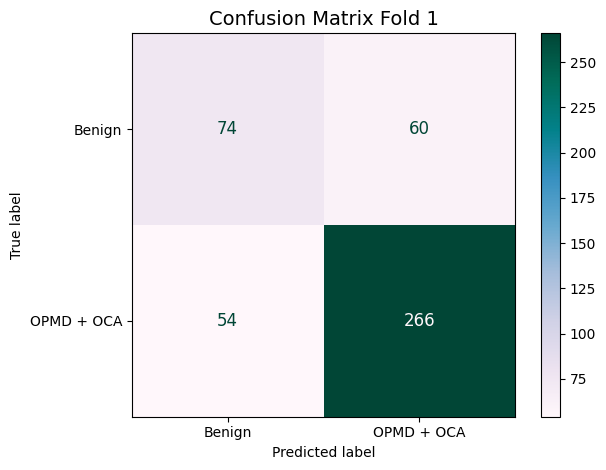


========== Fold 2 ==========

[Fold 2] Loading checkpoint from /kaggle/input/checkpoints/fold_2_epoch_280_unimodal_checkpoint.pt
Fold 2 Test Accuracy: 0.6762 | Macro F1: 0.6532 | Precision: 0.6538 | Recall: 0.6527


Initializing zero-element tensors is a no-op


<Figure size 1200x900 with 0 Axes>

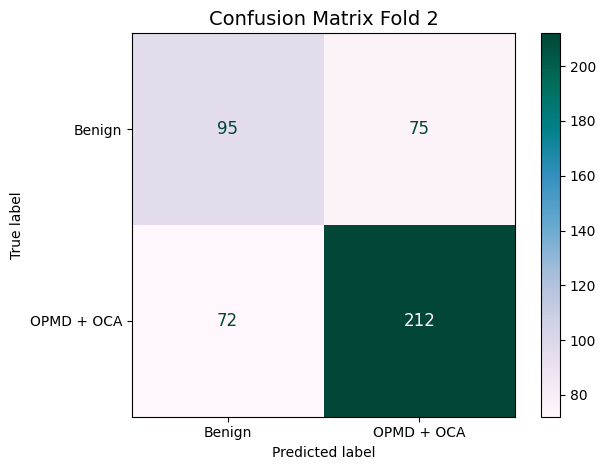


========== Fold 3 ==========

[Fold 3] Loading checkpoint from /kaggle/input/checkpoints/fold_3_epoch_280_unimodal_checkpoint.pt
Fold 3 Test Accuracy: 0.7313 | Macro F1: 0.7118 | Precision: 0.7163 | Recall: 0.7089


Initializing zero-element tensors is a no-op


<Figure size 1200x900 with 0 Axes>

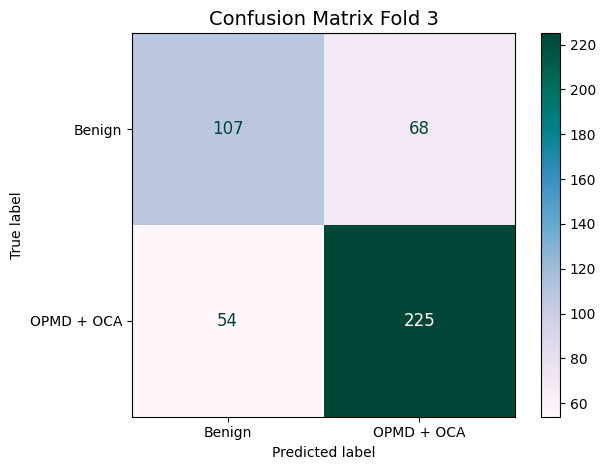


========== Fold 4 ==========

[Fold 4] Loading checkpoint from /kaggle/input/checkpoints/fold_4_epoch_280_unimodal_checkpoint.pt
Fold 4 Test Accuracy: 0.7291 | Macro F1: 0.7084 | Precision: 0.7042 | Recall: 0.7291


Initializing zero-element tensors is a no-op


<Figure size 1200x900 with 0 Axes>

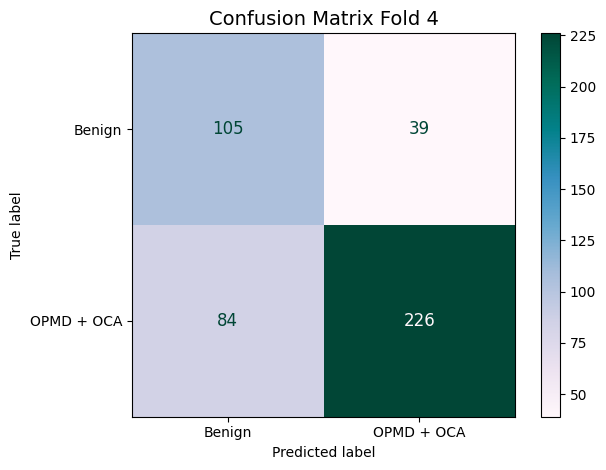


========== Fold 5 ==========

[Fold 5] Loading checkpoint from /kaggle/input/checkpoints/fold_5_epoch_280_unimodal_checkpoint.pt
Fold 5 Test Accuracy: 0.7709 | Macro F1: 0.7115 | Precision: 0.7126 | Recall: 0.7105


Initializing zero-element tensors is a no-op


<Figure size 1200x900 with 0 Axes>

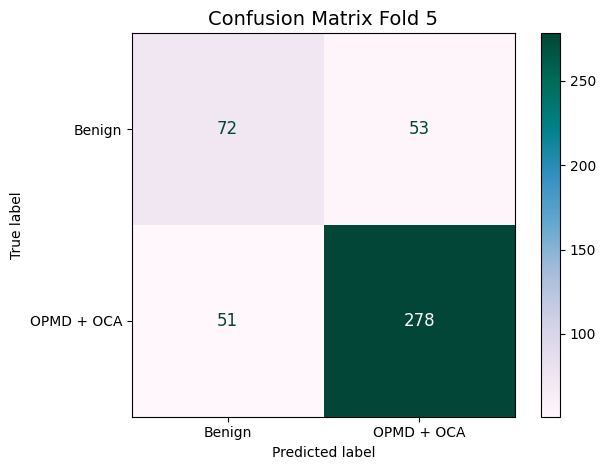


========== Cross-Validation Results ==========
Mean Accuracy: 0.7313 ± 0.0314
Mean Macro F1: 0.6958 ± 0.0223
Mean Precision: 0.6968 ± 0.0225
Mean Recall: 0.6986 ± 0.0258
Saved best fold test indices, labels, and predictions as .npy files.


In [18]:
if __name__ == "__main__":

    image_df = pd.read_csv('/kaggle/input/zenodo-oscc-dataset/Imagewise_Data.csv')
    patient_df = pd.read_csv('/kaggle/input/zenodo-oscc-dataset/Patientwise_Data.csv')
    
    # --- Preprocess ---
    image_df = image_df[image_df['Category'] != 'Healthy']
    image_df['Patient ID'] = image_df['Image Name'].str.rsplit('-', n=1).str[0]
    image_df = pd.merge(image_df, patient_df, on="Patient ID", how="left")
    groups = image_df['Patient ID'].tolist()
    
    image_df = image_df.drop(['Image Name', 'Patient ID'], axis=1)
    image_df['Age'] = image_df['Age'].fillna(image_df['Age'].mean())
    image_df['Gender'] = image_df['Gender'].fillna('M').map({'M': 1, 'F': 0})
    image_df['Image Count'] = image_df['Image Count'].fillna(0)
    
    # Encode Clinical Diagnosis based on custom scoring
    diagnoses = {
        diag: 10 * image_df[(image_df['Category'] == 'OCA') & (image_df['Clinical Diagnosis'] == diag)].shape[0]
              + image_df[(image_df['Category'] == 'OPMD') & (image_df['Clinical Diagnosis'] == diag)].shape[0]
              - image_df[(image_df['Category'] == 'Benign') & (image_df['Clinical Diagnosis'] == diag)].shape[0]
        for diag in image_df['Clinical Diagnosis'].unique()
    }
    sorted_diags = sorted(diagnoses.items(), key=lambda x: x[1])
    encoding_dict = {diag: idx for idx, (diag, _) in enumerate(sorted_diags)}
    image_df['Clinical Diagnosis'] = image_df['Clinical Diagnosis'].map(encoding_dict)

    # Encode habits
    for col in ['Smoking', 'Chewing_Betel_Quid ', 'Alcohol']:
        image_df[col] = image_df[col].fillna('No').map({'Yes': 1, 'No': 0})
    
    # Encode category (target)
    image_df['Category'] = image_df['Category'].map({'Benign': 0, 'OPMD': 1, 'OCA': 1})

    print(image_df.isna().sum().sum())
    print(len(image_df.select_dtypes(include=[np.number]).columns))
        
    embeddings = np.load('/kaggle/input/zenodo-oscc-dataset/embeddings_healthy_removed(2).npy')[:-748]
    labels = np.load('/kaggle/input/zenodo-oscc-dataset/labels_healthy_removed(2).npy')[:-748]

    train_and_evaluate_mlp(embeddings, labels, groups, image_df,mode=MODE,inference_only=INFERENCE_CHOICE)

## XGBoost Training to Determine the two most Important Metadata Columns

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# --- Load data ---
image_df = pd.read_csv('/kaggle/input/zenodo-oscc-dataset/Imagewise_Data.csv')
patient_df = pd.read_csv('/kaggle/input/zenodo-oscc-dataset/Patientwise_Data.csv')

# --- Preprocess ---
image_df = image_df[image_df['Category'] != 'Healthy']
image_df['Patient ID'] = image_df['Image Name'].str.rsplit('-', n=1).str[0]
image_df = pd.merge(image_df, patient_df, on="Patient ID", how="left")

image_df = image_df.drop(['Image Name', 'Patient ID'], axis=1)
image_df['Age'] = image_df['Age'].fillna(image_df['Age'].mean())
image_df['Gender'] = image_df['Gender'].fillna('M').map({'M': 1, 'F': 0})
image_df['Image Count'] = image_df['Image Count'].fillna(0)

# Encode Clinical Diagnosis based on custom scoring
diagnoses = {
    diag: 10 * image_df[(image_df['Category'] == 'OCA') & (image_df['Clinical Diagnosis'] == diag)].shape[0]
          + image_df[(image_df['Category'] == 'OPMD') & (image_df['Clinical Diagnosis'] == diag)].shape[0]
          - image_df[(image_df['Category'] == 'Benign') & (image_df['Clinical Diagnosis'] == diag)].shape[0]
    for diag in image_df['Clinical Diagnosis'].unique()
}
sorted_diags = sorted(diagnoses.items(), key=lambda x: x[1])
encoding_dict = {diag: idx for idx, (diag, _) in enumerate(sorted_diags)}
image_df['Clinical Diagnosis'] = image_df['Clinical Diagnosis'].map(encoding_dict)

# Encode habits
for col in ['Smoking', 'Chewing_Betel_Quid ', 'Alcohol']:
    image_df[col] = image_df[col].fillna('No').map({'Yes': 1, 'No': 0})

# Encode category (target)
image_df['Category'] = image_df['Category'].map({'Benign': 0, 'OPMD': 1, 'OCA': 1})

# --- XGBoost Feature Importance ---
X = image_df.drop(columns=['Category'])
y = image_df['Category']

# Train/val split (optional)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Print top 2 features
print("Top 2 most important features:")
print(feat_importance_df.head(7))

# Analysis

Mismatch at idices: (array([], dtype=int64),)
Mismatch at indices: (array([], dtype=int64),)
Mismatch at indices: (array([], dtype=int64),)
Misclassify by unimodal but correctly by mbf: [158 236 237 402 403] (size: 53)
Misclassify by mbf but correctly by maf: [367 531 620 621 764] (size: 16)
Misclassify by unimodal but correctly by maf: [158 402 403 457 496] (size: 55)


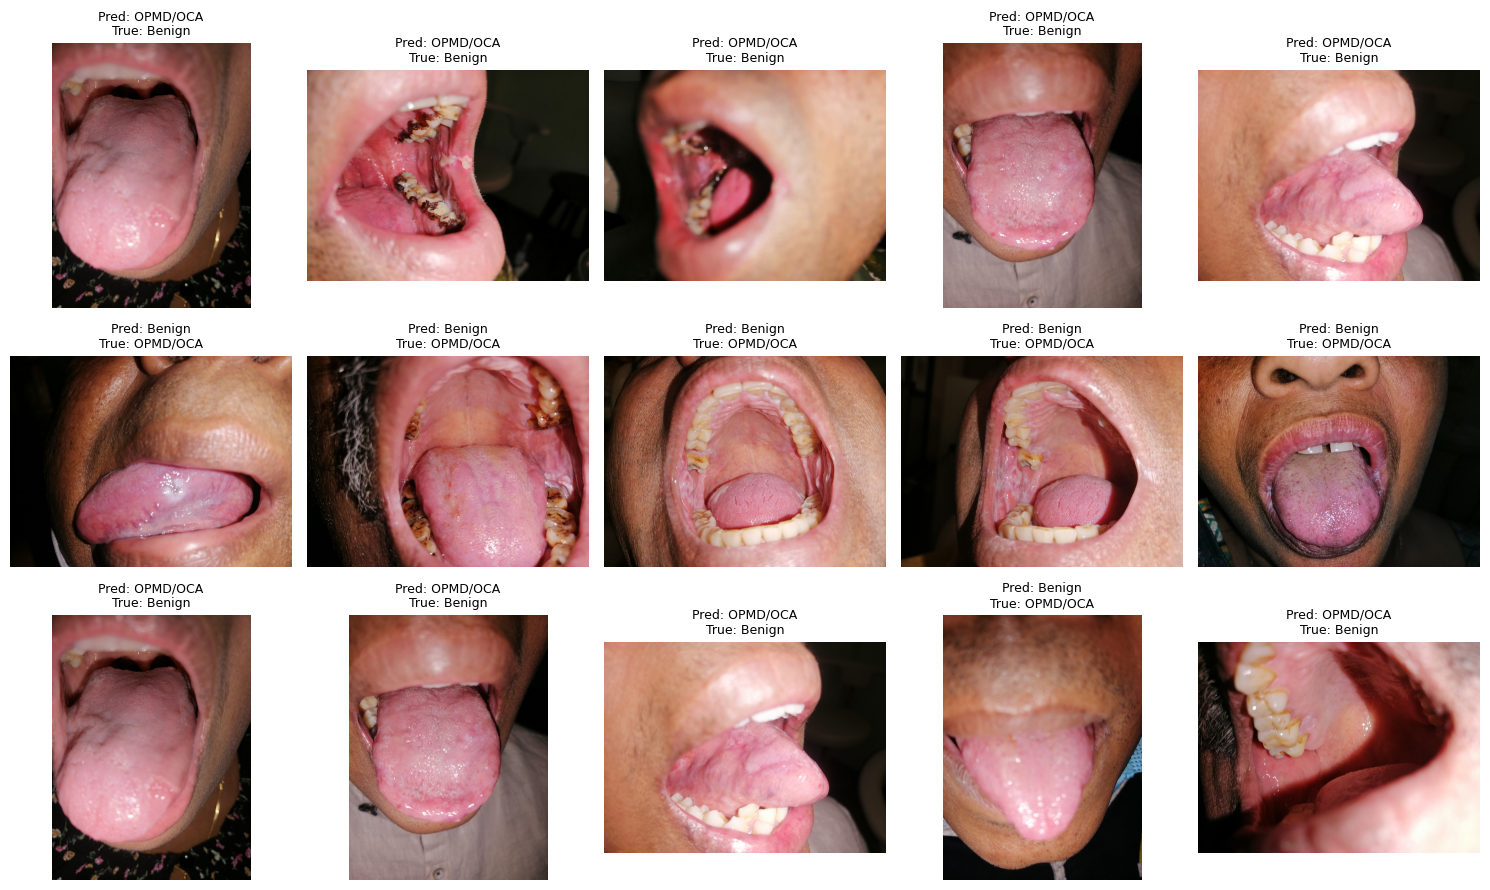

In [25]:
BASE_DIR = '/kaggle/input/zenodo-oscc-dataset/Zenodo_OSCC_Dataset/Zenodo_OSCC_Dataset'
df = pd.read_csv('/kaggle/input/zenodo-oscc-dataset/Imagewise_Data.csv')
df = df[df['Category']!='Healthy']
idxs_maf = np.load("/kaggle/working/best_fold_test_indices.npy")
categs = df.iloc[list(idxs_maf)]['Category'].tolist()
categs = [0 if cat == 'Benign' else 1 for cat in categs]
labels_maf = np.load("/kaggle/working/best_fold_test_labels.npy")
preds_maf = np.load("/kaggle/working/best_fold_test_preds.npy")
assert labels_maf.shape[0] == len(categs), f"Length mismatch - len(labels_maf) = {labels_maf.shape[0]}, len(categs) = {len(categs)}"
print(f"Mismatch at idices: {np.where(labels_maf!=categs)}")

idxs_mbf = np.load("/kaggle/working/best_fold_test_indices_mbf.npy")
print(f"Mismatch at indices: {np.where(idxs_maf!=idxs_mbf)}")
preds_mbf = np.load("/kaggle/working/best_fold_test_preds_mbf.npy")

idxs_u = np.load("/kaggle/working/best_fold_test_indices_u.npy")
print(f"Mismatch at indices: {np.where(idxs_maf!=idxs_u)}")
preds_u = np.load("/kaggle/working/best_fold_test_preds_u.npy")

import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

# 1️⃣ Misclassify by unimodal but correctly by mbf
mask_1 = (labels_maf != preds_u) & (labels_maf == preds_mbf)
idxs_1 = idxs_maf[np.where(mask_1)[0]][:5]
preds_1_u = preds_u[np.where(mask_1)[0]][:5]
labels_1 = labels_maf[np.where(mask_1)[0]][:5]
print(f"Misclassify by unimodal but correctly by mbf: {idxs_1} (size: {np.where(mask_1)[0].shape[0]})")

img_names_1 = df.iloc[idxs_1]['Image Name'].tolist()
categ_names_1 = df.iloc[idxs_1]['Category'].tolist()
imgs_1 = [Image.open(os.path.join(BASE_DIR, categ_names_1[i], img_names_1[i] + ".jpg")) for i in range(len(idxs_1))]

# 2️⃣ Misclassify by mbf but correctly by maf
mask_2 = (labels_maf != preds_mbf) & (labels_maf == preds_maf)
idxs_2 = idxs_maf[np.where(mask_2)[0]][:5]
preds_2_mbf = preds_mbf[np.where(mask_2)[0]][:5]
labels_2 = labels_maf[np.where(mask_2)[0]][:5]
print(f"Misclassify by mbf but correctly by maf: {idxs_2} (size: {np.where(mask_2)[0].shape[0]})")

img_names_2 = df.iloc[idxs_2]['Image Name'].tolist()
categ_names_2 = df.iloc[idxs_2]['Category'].tolist()
imgs_2 = [Image.open(os.path.join(BASE_DIR, categ_names_2[i], img_names_2[i] + ".jpg")) for i in range(len(idxs_2))]

# 3️⃣ Misclassify by unimodal but correctly by maf
mask_3 = (labels_maf != preds_u) & (labels_maf == preds_maf)
idxs_3 = idxs_maf[np.where(mask_3)[0]][:5]
preds_3_u = preds_u[np.where(mask_3)[0]][:5]
labels_3 = labels_maf[np.where(mask_3)[0]][:5]
print(f"Misclassify by unimodal but correctly by maf: {idxs_3} (size: {np.where(mask_3)[0].shape[0]})")

img_names_3 = df.iloc[idxs_3]['Image Name'].tolist()
categ_names_3 = df.iloc[idxs_3]['Category'].tolist()
imgs_3 = [Image.open(os.path.join(BASE_DIR, categ_names_3[i], img_names_3[i] + ".jpg")) for i in range(len(idxs_3))]

mapping = {0: 'Benign', 1: 'OPMD/OCA'}

# 🔹 Display images with predicted and true categories
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for row, (imgs, pred_arr, true_arr) in enumerate([
        (imgs_1, preds_1_u, labels_1),
        (imgs_2, preds_2_mbf, labels_2),
        (imgs_3, preds_3_u, labels_3)]):
    for col, img in enumerate(imgs):
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

        # Get the index in idxs_maf for this image
        if row == 0:
            idx = idxs_1[col]
        elif row == 1:
            idx = idxs_2[col]
        else:
            idx = idxs_3[col]

        pred_label = mapping[pred_arr[col]]
        true_label = mapping[true_arr[col]]
        axes[row, col].set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=9)

plt.tight_layout()
plt.show()


